In [1]:
import torch
import torch.nn as nn

[-0.14  -0.162 -0.002 ... -0.306  0.082  0.669]


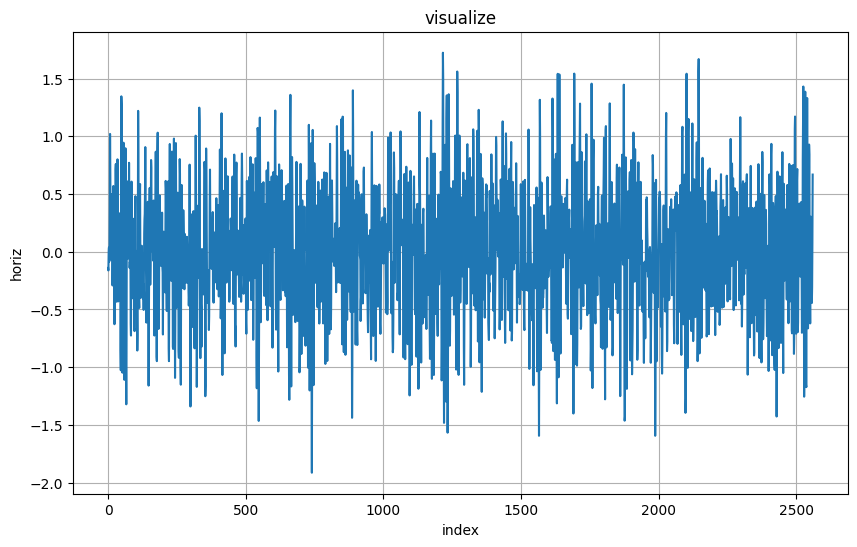

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bearing_path = '/Users/yentsokuo/git_repo/WKN_SSO/viberation_dataset/Learning_set/Bearing1_1/acc_00002.csv'
data = pd.read_csv(bearing_path, header=None, names=['hour', 'minute', 'second', 'microsecond', 'horiz accel', 'vert accel'])

inputs = data['horiz accel'].values.astype(float)
print(inputs)

plt.figure(figsize=(10, 6))
plt.plot(inputs)
plt.xlabel('index')
plt.ylabel('horiz')
plt.title('visualize')
plt.grid(True)
plt.show()


tensor([ 6.0131e-06,  5.5615e-01,  1.2303e-01,  ...,  3.4983e+00,
        -5.5721e-02, -1.1562e-04])


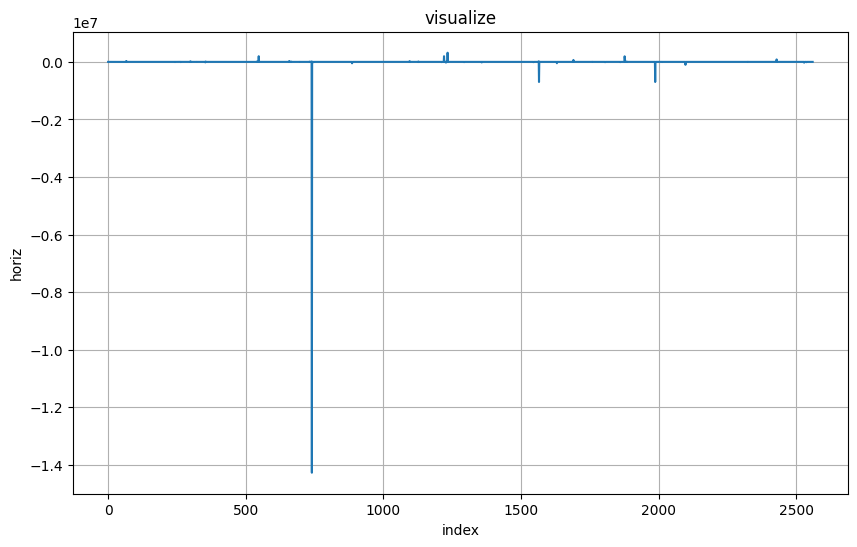

In [31]:
def Laplace(p):
    A = 0.08
    ep = 0.03
    tal = 0.1
    f = 50
    w = 2 * pi * f
    q = torch.tensor(1 - pow(ep, 2))
    
    y = A * torch.exp((-ep / (torch.sqrt(q))) * (w * (p - tal))) * (-torch.sin(w * (p - tal)))
    return y

input_tensor = torch.from_numpy(inputs.astype(np.float32))
i_LA = Laplace(input_tensor)
print(i_LA)

plt.figure(figsize=(10, 6))
plt.plot(i_LA)
plt.xlabel('index')
plt.ylabel('horiz')
plt.title('visualize')
plt.grid(True)
plt.show()

1.3313353638003897
tensor([ 0.8403,  0.6901,  1.3312,  ..., -0.4378,  1.1546, -0.5186])


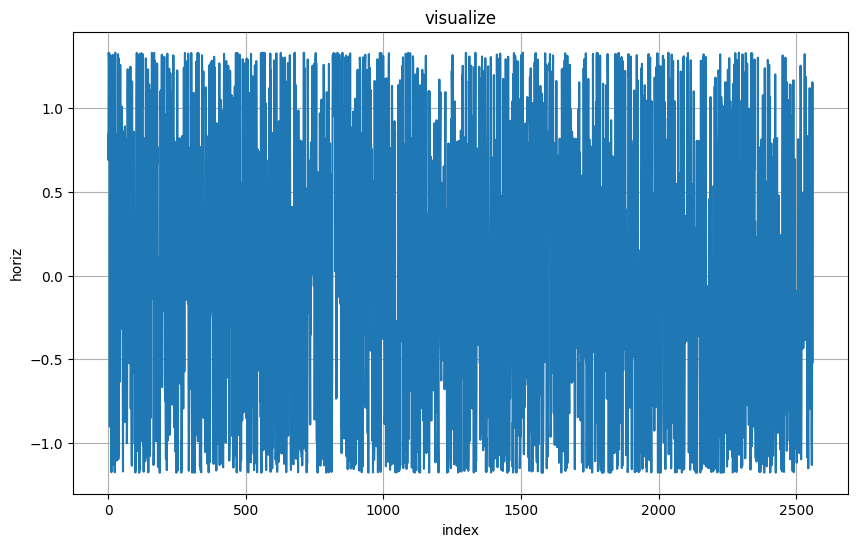

In [32]:
from math import pi
C = pow(pi, 0.25)
print(C)

def Morlet(p):
    C = pow(pi, 0.25)
    # p = 0.03 * p
    y = C * torch.exp(-torch.pow(p, 2) / 2) * torch.cos(2 * pi * p)
    return y

i_morlet = Morlet(input_tensor)
print(i_morlet)

plt.figure(figsize=(10, 6))
plt.plot(i_morlet)
plt.xlabel('index')
plt.ylabel('horiz')
plt.title('visualize')
plt.grid(True)
plt.show()

tensor([0.9708, 0.9611, 1.0000,  ..., 0.8649, 0.9899, 0.4417])


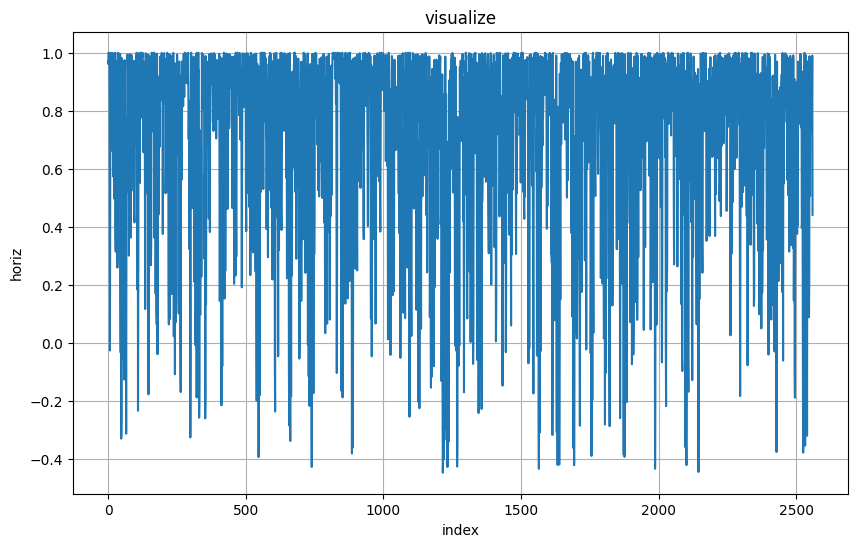

In [33]:
def Mexh(p):
    # p = 0.04 * p  # 将时间转化为在[-5,5]这个区间内
    y = (1 - torch.pow(p, 2)) * torch.exp(-torch.pow(p, 2) / 2)

    return y

i_Mexh = Mexh(input_tensor)
print(i_Mexh)

plt.figure(figsize=(10, 6))
plt.plot(i_Mexh)
plt.xlabel('index')
plt.ylabel('horiz')
plt.title('visualize')
plt.grid(True)
plt.show()

In [ ]:

class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttentionModel, self).__init__()
        # 線性層用於對特徵嵌入進行線性轉換
        self.linear = nn.Linear(input_dim, hidden_dim)
        # 自注意力機制層
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1)
        
    def forward(self, x):
        # 進行特徵嵌入的線性轉換
        x = self.linear(x)
        # 使用自注意力機制
        x, _ = self.attention(x, x, x)  # 對輸入x應用自注意力機制
        return x

# 創建模型
input_dim = 10  # 假設每個時間步有10個特徵
hidden_dim = 64  # 隱藏層維度
model = SelfAttentionModel(input_dim, hidden_dim)

# 輸入示例數據，這是一個批次大小為3，時間步數為5，特徵維度為10的數據
input_data = torch.rand(3, 5, 10)  # (batch_size, time_steps, input_dim)

# 前向傳播
output = model(input_data)

# 查看輸出形狀
print(output.shape)  # 將顯示 torch.Size([3, 5, 64])

In [ ]:

class WaveletKernelNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(WaveletKernelNetwork, self).__init()
        # Wavelet Kernel Network 部分，你可以根據需求擴展這部分
        self.wkn_layer = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
    def forward(self, x):
        x = self.wkn_layer(x)
        return x

class SelfAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SelfAttentionModel, self).__init()
        # 線性層用於對特徵嵌入進行線性轉換
        self.linear = nn.Linear(input_dim, hidden_dim)
        # 自注意力機制層
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=1)
        
    def forward(self, x):
        # 進行特徵嵌入的線性轉換
        x = self.linear(x)
        # 使用自注意力機制
        x, _ = self.attention(x, x, x)  # 對輸入x應用自注意力機制
        return x

class WKN_LSTM_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WKN_LSTM_SelfAttention, self).__init()
        # Wavelet Kernel Network 部分
        self.wkn = WaveletKernelNetwork(input_dim, hidden_dim)
        # LSTM 層
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        # 自注意力層
        self.self_attention = SelfAttentionModel(hidden_dim, hidden_dim)
        # 全連接層
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Wavelet Kernel Network 部分
        x = self.wkn(x)
        # LSTM 層
        x, _ = self.lstm(x)
        # 自注意力層
        x = self.self_attention(x)
        # 全連接層
        x = self.fc(x)
        return x


In [13]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# from src.dataset_loader import CustomDataSet

import sys
sys.path.append("/Users/yentsokuo/git_repo/WKN_SSO/src/dataset_loader.py/")
import CustomDataSet

Learning_set = './viberation_dataset/Learning_set/'
work_condition = 1

train_data = CustomDataSet(Learning_set, work_condition)
print(train_data.shape)

ModuleNotFoundError: No module named 'CustomDataSet'

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

folder_name = './viberation_dataset/Test_set/Bearing1_3/'
files = [file for file in sorted(os.listdir(folder_name)) if 'acc' in file]
# print(files)

hrz_data_list = []
for file in files:
    df_hrz = pd.read_csv(f'{folder_name}/{file}', header=None)
    df_hrz = df_hrz[4]
    hrz_data_list.append(df_hrz) 

hrz_data = np.array(hrz_data_list)
scaler = MinMaxScaler(feature_range=(-1, 1))
hrz_data = scaler.fit_transform(hrz_data)
print(hrz_data.shape)


FileNotFoundError: [Errno 2] No such file or directory: './viberation_dataset/Test_set/Bearing1_3/'

In [ ]:
print(hrz_data)

In [ ]:
hrz_data_1d = hrz_data.reshape(-1)
print(hrz_data_1d.shape)

In [ ]:
print(hrz_data_1d)

In [12]:
from src.model import *
import numpy as np
import torch

model = LA_WKN_BiGRU()
# model = Laplace_fast(32,64)

print(model)


ModuleNotFoundError: No module named 'src'

In [ ]:
a = np.random.rand(1, 2560)
a = torch.from_numpy(a.astype(np.float32))
print(a.shape)

y = model(a)
y

In [ ]:
c = Laplace(a)
# s = (c).view(32, 1, 63)
print(c.shape)

In [ ]:
out_channels = 32
a_ = nn.Parameter(torch.linspace(1, 10, out_channels)).view(-1, 1)
b_ = nn.Parameter(torch.linspace(0, 10, out_channels)).view(-1, 1)

time_disc = torch.linspace(0, 1, steps=int((63)))
p1 = time_disc.unsqueeze(0) - b_ / a_
laplace_filter = Laplace(p1)

laplace_filter.shape